### Models
This is a probabilistic data-driven representation of the process/simulator that the user is working with. There is normally a modelling framework that is used to create a model. Examples: neural network, Gaussian process, random forest. 

Emukit does not mandate or make any assumptions about a particular modelling technique or a library. Instead it suggests to implement a subset of defined model interfaces required to use a particular method. Nevertheless, there are a few model-related functionalities in Emukit: - Example models, which give users something to play with to explore Emukit. - Model wrappers, which are designed to help adapting models in particular modelling frameworks to Emukit interfaces. - Multi-fidelity models, implemented based on GPy.

Emukit already provide a wrapper for using a model created with GPy. For instructions on how to include your own model please see this notebook (https://emukit.readthedocs.io/en/latest/notebooks/Emukit-tutorial-custom-model.html).

Different models and modelling frameworks will provide different functionality. For instance a Gaussian process will usually have derivatives of the predictions available but random forests will not. These different functionalities are represented by a set of interfaces which a model implements. The basic interface that all models must implement is IModel, which implements functionality to make predictions and update the model but a model may implement any number of other interfaces such as IDifferentiable which indicates a model has prediction derivatives available.

### Methods. 
Relatively low-level techniques that are aimed at either understanding, quantifying or using uncertainty that the model provides. Examples: Bayesian optimization, experimental design.
 
### Tasks 
High level goals that owners of the process/simulator might be actually interested in. Examples: measure quality of a simulator, explain complex system behavior.



## Options available
Thecurrent version of Emukit includes multi-fidelity emulation for build surrogate models when data is obtained from multiple information sources that have different fidelity and/or cost; Bayesian optimisation for optimising physical experiments and tune parameters of machine learning algorithms or other computational simulations; experimental design and active learning: design the most informative experiments and perform active learning with machine learning models; sensitivity analysis: analyse the influence of inputs on the outputs of a given system; and Bayesian quadrature: efficiently compute the integrals of functions that are expensive to evaluate. But it’s easy to extend.

## Loop
The emukit.core.loop.OuterLoop class is the abstract loop where the different components come together. There are more specific loops for Bayesian optimization and experimental design that construct some of the component parts for you.

In [1]:
import numpy as np
import GPy
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop

from emukit.model_wrappers import SimpleGaussianProcessModel 
# Simple model wrapper Emukit provides for a basic form of Gaussian 
# process. Alternatively we can use GPy

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper

import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

In [2]:
ExperimentalDesignLoop?

### Create data

In [3]:
x_min = -30.0
x_max = 30.0

x = np.random.uniform(x_min, x_max, (10, 1))
y = np.sin(x) + np.random.randn(10, 1) * 0.05

### Include model
Check https://github.com/EmuKit/emukit/blob/master/notebooks/Emukit-tutorial-custom-model.ipynb to learn about how to include your own model in Emukit

In [4]:
emukit_model = SimpleGaussianProcessModel(x, y)

In [5]:
p = ContinuousParameter('c', x_min, x_max)
space = ParameterSpace([p])

### Main loop

The loop can be used in two modes:

1. Emukit calculates the next point(s) to try and evaluates your function at these points until some stopping
   criterion is met.
2. Emukit only calculates the next points(s) to try and you evaluate your function or perform the experiment.

In [6]:
loop = ExperimentalDesignLoop(
    space=space, 
    model=emukit_model,
    acquisition=None,
    update_interval=1,
    batch_size=1,
    acquisition_optimizer=None,
)
loop.run_loop(np.sin, 30)


In [7]:
plot_min = -40.0
plot_max = 40.0

real_x = np.arange(plot_min, plot_max, 0.2)
real_y = np.sin(real_x)

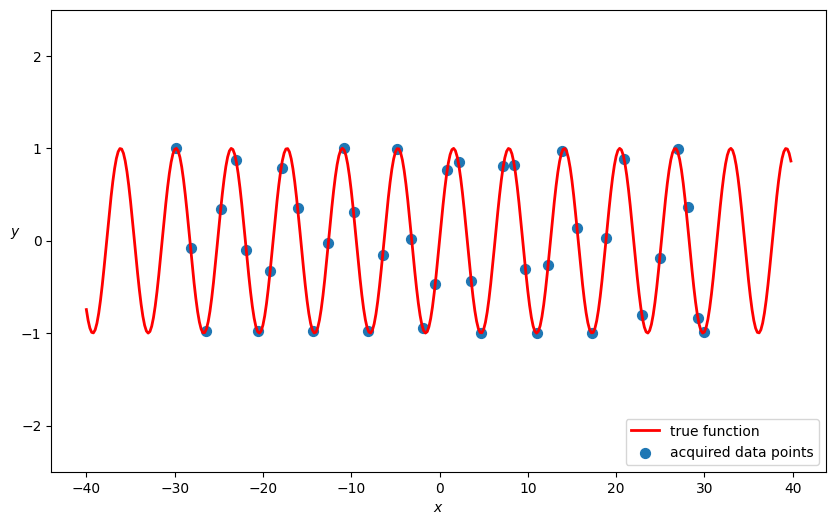

In [8]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

ax.plot(real_x, real_y, c='r', linewidth=2)
ax.scatter(loop.loop_state.X[:, 0].tolist(), 
           loop.loop_state.Y[:, 0].tolist(), s=50)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$', rotation=None)
ax.set_ylim([-2.5, 2.5])

ax.legend(['true function', 'acquired data points'], loc='lower right')

mlai.write_figure('emukit-sine-function.svg', directory='./uq')

In [9]:
predicted_y = []
predicted_std = []
for x in real_x:
    y, var = emukit_model.predict(np.array([[x]]))
    std = np.sqrt(var)
    predicted_y.append(y)
    predicted_std.append(std)

predicted_y = np.array(predicted_y).flatten()
predicted_std = np.array(predicted_std).flatten()

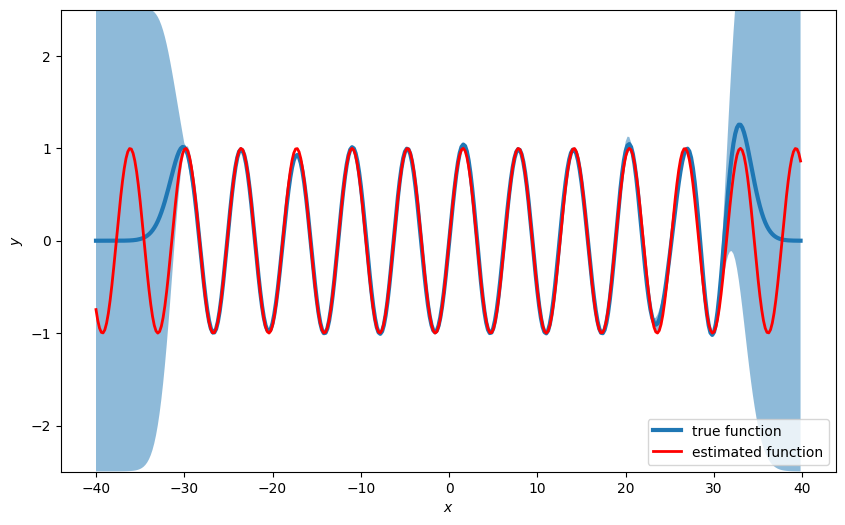

In [10]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

ax.plot(real_x, predicted_y, linewidth=3)
ax.plot(real_x, real_y, c='r', linewidth=2)

ax.set_ylim([-2.5, 2.5])

ax.fill_between(real_x, predicted_y - 2 * predicted_std, 
                predicted_y + 2 * predicted_std, alpha=.5)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(['true function', 'estimated function'], loc='lower right')

mlai.write_figure('emukit-sine-function-fit.svg', directory='./uq')